# Import libraries

In [51]:

# !tar -xf "/content/20news-bydate-matlab.tgz"

import os
import tarfile
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Extract Tar file

In [52]:
def extract_tar(path: str, dest: str) -> None:
  """
  Description: Extracts the contents of a tar file to specified destination.
  ----------------------------------------------------------------
  Input:
  path: str
  Path of folder to untar.

  dest: str
  Destination folder to untar to.

  ----------------------------------------------------------------

  Output: None
  """
  file= tarfile.open(path)
  file.extractall(dest, filter='data')
  file.close()

  print("Extraction complete!")

extract_tar("/content/20news-bydate-matlab.tgz", "/content/")

Extraction complete!


# Load files

In [53]:
matlab_dir= "/content/20news-bydate/matlab"


def convert_to_csv(file, dtype='data'):
  """
  Description: Open the corresponding data file and convert it to a pandas dataframe.
  ----------------------------------------------------------------
  Input:
  path: str
  Path of file to open

  dtype: str
  The  type of file inputted [ data, label, map]

  ----------------------------------------------------------------

  Output: pd.Dataframe
  """
  try:
    df= pd.read_csv(matlab_dir+f"/{file}", header= None, names=['raw_data'])

    if dtype=="data":
      temp_df = [ d.split(" ")  for d in df['raw_data']]
      columns= ['doc_id', 'word_id', 'count']
      data= pd.DataFrame(temp_df, columns=columns)
      for c in columns:
        data[c]= pd.to_numeric(data[c])
      data['word_id'] -=1
      data['doc_id'] -=1
      return data

    elif dtype == 'label':
      data= df.rename(columns={'raw_data':'label_id'})
      data['label_id'] = pd.to_numeric( data['label_id'])
      data['label_id'] -=1
      return data

    elif dtype=='map':
      temp_df = [ d.split(" ")  for d in df['raw_data']]
      data= pd.DataFrame(temp_df, columns=['label_name', 'label_id'])
      data['label_id'] = pd.to_numeric(data['label_id'])
      data['label_id'] -=1
      return data

  except Exception as e:
    print(e)

In [54]:
# load the vocabulary file and convert it into a dataframe with word index
with open('vocabulary.txt') as f:
        vocab = f.read().splitlines()
        vocabulary = pd.DataFrame(vocab, columns=['word'])
        vocabulary.insert(0, 'word_idx', range(0, len(vocabulary)))
        print(vocabulary.head())
        print("Loaded vocabulary!")

   word_idx       word
0         0    archive
1         1       name
2         2    atheism
3         3  resources
4         4        alt
Loaded vocabulary!


In [55]:
def load_data(data_type= 'train'):
  """
  Description: Loads data, label and map files for a type of dataset
  and returns 3 dataframes respectively.
  ----------------------------------------------------------------
  Input:
  data_type: str
  Dataset type to load

  ----------------------------------------------------------------

  Output:
  data: pd.Dataframe
  label: pd.Dataframe
  map: pd.Dataframe
  """
  if data_type in ['train', 'test']:
    print(f"Loading {data_type} files...")
    data= convert_to_csv(f'{data_type}.data')
    label = convert_to_csv(f'{data_type}.label','label')
    map = convert_to_csv(f'{data_type}.map','map')
    print(f"Loading {data_type} complete!")
    return data, label, map
  else:
    return None

train_data,train_label,train_map = load_data('train')

test_data,test_label,test_map = load_data('test')

train_map['label_id'] = train_map['label_id']
train_label = train_label.merge(train_map, how='left',  on='label_id')
train_data = train_data.merge(vocabulary, how='left', left_on='word_id', right_on='word_idx')
train_data = train_data.merge(train_label, how='left', left_on='doc_id', right_index=True)
train_data= train_data.drop(columns=['word_idx'], axis=1)


test_map['label_id'] = test_map['label_id']
test_label = test_label.merge(test_map, how='left', on='label_id')
test_data = test_data.merge(vocabulary, how='left', left_on='word_id', right_on='word_idx')
test_data = test_data.merge(test_label, how='left', left_on='doc_id', right_index=True)
test_data= test_data.drop(columns=['word_idx'], axis=1)


vocab_counts= train_data['word_id'].value_counts()

Loading train files...
Loading train complete!
Loading test files...
Loading test complete!


# Performing EDA

In [56]:
print(f"Number of words in vocabulary: {len(vocabulary)}")
print( f"Vocabulary without lowercase: {len(vocabulary[vocabulary['word'].str.islower()==False])}")
print( f"Vocabulary with spacing: {len(vocabulary[vocabulary['word'].str.contains(r'\s')==True])}")
print(f"Number of records in train: {len(train_data)}")
print(f"Number of records in train: {len(test_data)}")

Number of words in vocabulary: 61188
Vocabulary without lowercase: 0
Vocabulary with spacing: 0
Number of records in train: 1467345
Number of records in train: 967874


Mean number of documents per category: 563.45
Median number of documents : 589.0
Max length of document : 11233
Min length of document : 2
Mean length of document : 245.39000798651168


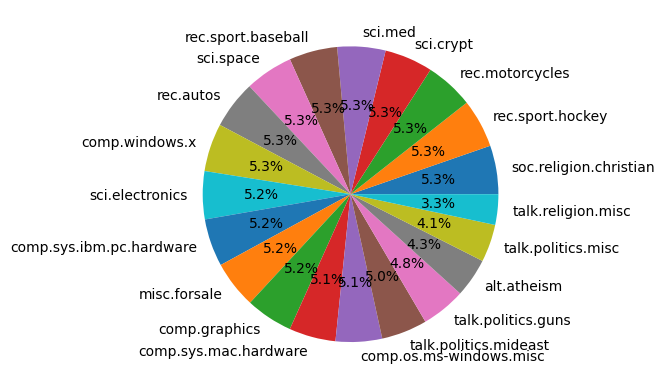

In [57]:
# Check the document distribution in each category
label_count= train_data.groupby(['doc_id'])['label_name'].first().value_counts()

print(f"Mean number of documents per category: {label_count.mean()}")
print(f"Median number of documents : {label_count.median()}")

document_length=train_data.groupby(['doc_id'])['count'].sum()
print(f"Max length of document : {max(document_length)}")
print(f"Min length of document : {min(document_length)}")
print(f"Mean length of document : {document_length.reset_index()['count'].mean()}")

plt.pie(label_count, labels= label_count.index, autopct='%1.1f%%')
plt.show()

# Perform Data Preprocessing

In [58]:
def remove_freq(data, freq= 2, filter_type="max"):
  """
  Description: Remove words with low/high frequency from the train dataset and
  return the vocabulary of these low and high frequency words to filter them from
   the test dataset
  ----------------------------------------------------------------
  Input:
  data: pd.Dataframe
  Dataset to determine words to filter

  freq: int, default= 1
  Frequency of words to filter

  filter_type: str, default= "max"
  Type of filter to perform [max, min]

  ----------------------------------------------------------------

  Output:
  filter_freq: pd.Dataframe
  Filtered dataset

  x: pd.Dataframe
  Vocabulary of low/high frequency words

  """

  if filter_type=="max":
    x= data.groupby(['word'], sort=False)['doc_id'].nunique().reset_index()
    x= x[x['doc_id'] > freq ]['word'].tolist()

  elif filter_type=="min":
    x = data.groupby(['word'], sort=False)['count'].sum().reset_index()
    x= x[x['count'] < freq]['word'].tolist()

  filter_freq= data[data['word'].isin(x) == False].copy()
  filter_freq= filter_freq.reset_index(drop=True)
  return  filter_freq, x


def remove_stop_words(data):
  """
  Description: Removes stop words present within the provided dataset.

  ----------------------------------------------------------------

  Input: pd.DataFrame
  Data to remove stop words from

  ----------------------------------------------------------------

  Output: pd.DataFrame
  Dataset with stop words removed
  """
  stop_words= stopwords.words('english')
  stop_removed=  data[ data['word'].isin(stop_words) ==False].copy()
  stop_removed.reset_index(drop= True,inplace=True)

  return stop_removed

def snow_stem(data):
  """
  Description: Use stemming to stem words within the provided dataset.

  ----------------------------------------------------------------

  Input: pd.DataFrame
  Data to stem words within

  ----------------------------------------------------------------

  Output: pd.DataFrame
  Dataset with stemmed words
  """
  snow= nltk.stem.SnowballStemmer('english')
  data['word']= data['word'].apply(lambda x: snow.stem(x))
  return data

def lemma(data):
  """
  Description: Use lemmatization to lemmatize words within the provided dataset.

  ----------------------------------------------------------------

  Input: pd.DataFrame
  Data to lemmatize words within

  ----------------------------------------------------------------

  Output: pd.DataFrame
  Dataset with lemmatized words
  """
  lemm= nltk.stem.WordNetLemmatizer()
  data['word']= data['word'].apply(lambda x: lemm.lemmatize(x))
  return data

def form_word_cloud(data):
  """
  Description: Create a word cloud to visualize the distribution of words in the dataset.

  -----------------------------------------------------------------------------------

  Input: pd.DataFrame
  List of words for which word cloud must be created

  -----------------------------------------------------------------------------------

  Output: None
  """
  w= WordCloud( collocations= False ,width=1500, height=1200, background_color="white",max_words= len(vocabulary)).generate(" ".join(data.astype(str).to_list()))

  plt.imshow(w)
  plt.axis('off')
  plt.show()


def reset_data(data):
  """
  Description: Reset the count of each word in a document

  -----------------------------------------------------------------------------------
  Input: pd.DataFrame
  Data for which word count must be reset

  -----------------------------------------------------------------------------------

  Output: pd.DataFrame
  Data with resetted count

  """
  res= data.groupby([ 'doc_id','word', 'word_id', 'label_id'],sort=False)['count'].sum()
  res=res.reset_index()

  return res

In [59]:
# remove stop words
# removed all the stop words and reset the indexing for train and test
print('Removing stop words...')
train_data = remove_stop_words(train_data)
test_data = remove_stop_words(test_data)
vocabulary = remove_stop_words(vocabulary)

# stemming
# stemmed all the words in train and test
print("Performing stemming...")
stemmed_train= snow_stem(train_data)
stemmed_test= snow_stem(test_data)

print("Updating vocabulary and word indexing...")
stem_vocabulary = snow_stem(vocabulary)
print(train_data['word'].isna().sum(), test_data['word'].isna().sum(), vocabulary['word'].isna().sum())


# # modify the vocabulary
# create a new vocabulary dictionary using train
vocab = vocabulary['word'].unique()
vocab_updated = pd.DataFrame(vocab, columns=['word']).reset_index().rename(columns={'index': 'word_id'}) #update the indexing


# # drop the word indexing existing in data
# update the word indexing in train using the updated vocab
print("Mapping new indexing to train and test sets")
train_data = stemmed_train.drop(columns= ['word_id'])
train_data= train_data.merge(vocab_updated, how='left', left_on='word', right_on='word')



# update the word indexing using the new vocabulary
test_data = stemmed_test.drop(columns= ['word_id'])
test_data= test_data.merge(vocab_updated, how='left',  left_on='word', right_on='word')


# remove low frequency words from the data
# print("Removing low frequency words from the dataset..")
# train_data, low_freq_vocab = remove_freq(train_data, freq=3, filter_type="min")
# rem_test_low_freq = test_data[test_data['word'].isin(low_freq_vocab)==False].copy()
# test_data = rem_test_low_freq.reset_index()

# print(train_data['word'].isna().sum(), test_data['word'].isna().sum(), vocabulary['word'].isna().sum())

# resetting indexing and summing up count of duplicates present in data to make everything uniform
# recalculate the occurence of words and update count
print("Recalculating the count of each word per document...")
train_data= reset_data(train_data)
test_data= reset_data(test_data)





Removing stop words...
Performing stemming...
Updating vocabulary and word indexing...
0 0 0
Mapping new indexing to train and test sets
Recalculating the count of each word per document...


# Generate Synthetic Data for balancing labels

In [60]:
# data augmentation
import random
def make_samples(data,vocabulary,label_id,target= 1):
  """
  Description: Loads data, label and generate 'target' number of new samples composing of
  vocabulary from the same label's documents
  ----------------------------------------------------------------
  Input:
  data: pd.Dataframe
  Dataset to generate synthetic data from

  vocabulary: pd.Dataframe
  Vocabulary to reference words based on word index

  label_id: int
  Label id for which samples must be generated

  target: int, default=1
  Number of samples to generate

  ----------------------------------------------------------------

  Output:
  new_samples: pd.Dataframe
  Dataframe with new document samples generated
  """

  # making a sample for target n docs
  vocab= data[data['label_id'] == label_id]['word_id'].unique().tolist()
  # print([updated_])
  doc_len = random.randint(5,1000)
  max_doc_id = data['doc_id'].max()

  new_samples= pd.DataFrame(columns= ['doc_id', 'word', 'word_id','label_id'])

  for i in range(target):
    doc_id = max_doc_id + i + 1
    doc_ids= []
    words=[]
    word_ids= []
    label_ids= []

    # for 1 document
    for j in range(doc_len):
      word_id= int(random.choice(vocab))
      # print(word_id)
      word_ids.append(word_id)
      words.append(vocabulary[vocabulary['word_id'] == word_id]['word'].values[0])

      doc_ids.append(doc_id)
      label_ids.append(label_id)
    new_samples=pd.concat([new_samples,pd.DataFrame({
        'doc_id': doc_ids,
        'word': words,
        'word_id': word_ids,
        'label_id': label_ids,
    })], sort=False)
  new_samples= new_samples.groupby(['doc_id','word','word_id', 'label_id']).value_counts()
  new_samples= new_samples.reset_index()
  new_samples.rename(columns={0: 'count'}, inplace=True)
  return new_samples

print("Generating synthetic data...")
label_count= train_data.groupby(['doc_id'])['label_id'].first().value_counts()
TARGET= 599
for label_id in label_count.keys():
  if label_count[label_id] < TARGET:
    needed_samples= TARGET- label_count[label_id]
    print(f"Label {label_id} need to add {needed_samples} more documents")

    new_samples= make_samples(train_data,vocab_updated, label_id, needed_samples)
    train_data= pd.concat([train_data,new_samples], ignore_index=True)


Generating synthetic data...
Label 10 need to add 1 more documents
Label 8 need to add 3 more documents
Label 11 need to add 5 more documents
Label 13 need to add 5 more documents
Label 9 need to add 5 more documents
Label 14 need to add 6 more documents
Label 7 need to add 7 more documents
Label 5 need to add 7 more documents
Label 12 need to add 8 more documents
Label 3 need to add 12 more documents
Label 6 need to add 17 more documents
Label 1 need to add 18 more documents
Label 4 need to add 24 more documents
Label 2 need to add 27 more documents
Label 17 need to add 35 more documents
Label 16 need to add 54 more documents
Label 0 need to add 119 more documents
Label 18 need to add 135 more documents
Label 19 need to add 223 more documents


# Convert into Documents into Vectors

In [61]:
# creating count vector for bag of words approach
tf_idf= TfidfTransformer()

def transform_tdidf(tf_idf, data, vocab_size, tf_type= "fit"):
  """
  Description: Convert Dataframe of words and documents into count vectors and
  then perform TF-IDF transformation.
  ----------------------------------------------------------------
  Input:
  tf_idf: object
  Initialized TF-IDF transformer

  data: pd.DataFrame
  data to be converted into vector format

  vocab_size: int
  total number of words in vocabulary

  tf_type: str, default= "fit
  type of transformation to be performed depending on test or train data

  ----------------------------------------------------------------

  Output:
  TF-IDF transformed sparse matrix

  """

  sparse_matrix= coo_matrix(
        (data['count'].to_list(),
        (data['doc_id'].to_list(), data['word_id'].to_list() )
        ),
        shape= (max(data['doc_id'])+1, vocab_size)
    )
  if tf_type == "fit":
    return tf_idf.fit_transform(sparse_matrix)
  elif tf_type== "transform":
    return tf_idf.transform(sparse_matrix)


train_tfidf= transform_tdidf(tf_idf,train_data, len(vocab_updated))
test_tfidf= transform_tdidf(tf_idf,test_data, len(vocab_updated), tf_type="transform")

In [62]:
train_label = train_data.groupby(['doc_id'], sort=False)['label_id'].first().reset_index()
y_test= test_label['label_id']


# Classification using Logistic Regression

In [64]:
# classify using logistic regression
logistic_reg = LogisticRegression(max_iter=1000 )
logistic_reg.fit(train_tfidf, train_label['label_id'])

log_reg_pred= logistic_reg.predict(test_tfidf)

log_class_report= classification_report(y_test, log_reg_pred, target_names= train_map['label_name'].unique())
print(log_class_report)

                          precision    recall  f1-score   support

             alt.atheism       0.71      0.72      0.71       318
           comp.graphics       0.68      0.76      0.72       389
 comp.os.ms-windows.misc       0.74      0.65      0.69       391
comp.sys.ibm.pc.hardware       0.71      0.73      0.72       392
   comp.sys.mac.hardware       0.80      0.81      0.81       383
          comp.windows.x       0.82      0.75      0.78       390
            misc.forsale       0.75      0.84      0.79       382
               rec.autos       0.90      0.86      0.88       395
         rec.motorcycles       0.97      0.92      0.94       397
      rec.sport.baseball       0.89      0.91      0.90       397
        rec.sport.hockey       0.94      0.94      0.94       399
               sci.crypt       0.94      0.85      0.89       395
         sci.electronics       0.70      0.73      0.71       393
                 sci.med       0.87      0.83      0.85       393
         

# Classification using Naive Bayes method

In [66]:
# classify using naive bayes
naive_bayes= MultinomialNB()
naive_bayes.fit(train_tfidf, train_label['label_id'])
naive_pred= naive_bayes.predict(test_tfidf)
naive_class_report= classification_report(y_test, naive_pred, target_names= train_map['label_name'].unique())
print(naive_class_report)

                          precision    recall  f1-score   support

             alt.atheism       0.74      0.68      0.71       318
           comp.graphics       0.73      0.75      0.74       389
 comp.os.ms-windows.misc       0.75      0.68      0.71       391
comp.sys.ibm.pc.hardware       0.63      0.78      0.70       392
   comp.sys.mac.hardware       0.77      0.78      0.78       383
          comp.windows.x       0.87      0.75      0.81       390
            misc.forsale       0.90      0.72      0.80       382
               rec.autos       0.88      0.90      0.89       395
         rec.motorcycles       0.94      0.94      0.94       397
      rec.sport.baseball       0.96      0.91      0.94       397
        rec.sport.hockey       0.93      0.97      0.95       399
               sci.crypt       0.75      0.94      0.83       395
         sci.electronics       0.82      0.62      0.70       393
                 sci.med       0.93      0.79      0.85       393
         